1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import trapz

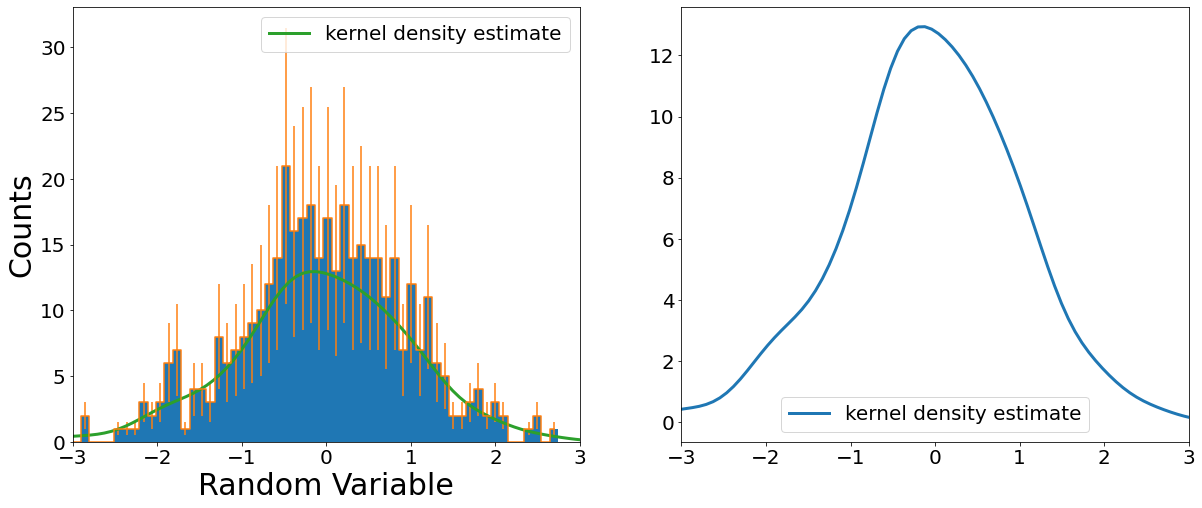

In [4]:
mean = 0
std = 1
N = 400

x = np.random.normal(mean,std, size=N)




fig, axs = plt.subplots(nrows = 1, ncols=2,figsize=(20,8))

y = axs[0].hist(x, bins=60)

bin_edges = y[1]
y = y[0]

bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

axs[0].errorbar( bin_centers, y, yerr = y**1/2, drawstyle='steps-mid')



axs[0].set_ylabel('Counts', fontsize=30)
axs[0].set_xlabel('Random Variable', fontsize=30)

axs[0].set_yticks(np.arange(0,45,5))
axs[0].tick_params(labelsize=20)


gauss = np.empty(shape=[0,100])

x_m = np.linspace(-4,4,100)
std_m = 1.06 * x.std() * x.size**(-1/5.)

for m in x:
    gauss = np.vstack((gauss,norm.pdf(x_m,loc=m, scale= std_m)))
    
gauss_sum = np.sum(gauss, axis=0)
scale_factor = trapz(gauss_sum)/N

gauss_sum = gauss_sum/scale_factor

axs[0].plot(x_m, gauss_sum, linewidth=3, label='kernel density estimate')
axs[0].set_xlim(-3,3)

axs[0].legend(fontsize=20)

#for g in gauss:
#    axs[1].bar(x_m,g, alpha=0.3 )

axs[1].plot(x_m, gauss_sum, linewidth=3, label='kernel density estimate')
axs[1].set_xlim(-3,3)
    
axs[1].tick_params(labelsize=20)

axs[1].legend(fontsize=20)
    

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

--2021-12-13 15:04:45--  https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png [following]
--2021-12-13 15:04:46--  https://www.dropbox.com/s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc10622ef9db1b289f26443ad779.dl.dropboxusercontent.com/cd/0/inline/BbyjmdwSHXMTQQ5c-wEaacc10Oy6P4PIv-vZraLyS9ayD8uwpIoRSOu7c_86C7JtOhOWcejZC5sgYoFrsTlz47G3h2PVvG3CyBTBxgS871j5k3DG_tfku2s86g9kNfByPfVYS2sQ2Iyiojw4frDn47ar/file# [following]
--2021-12-13 15:04:46--  https://uc10622ef9db1b289f26443ad779.dl.dropboxusercontent.com/cd/0/inline/BbyjmdwSHXMTQQ5c-wEaacc10Oy6P4

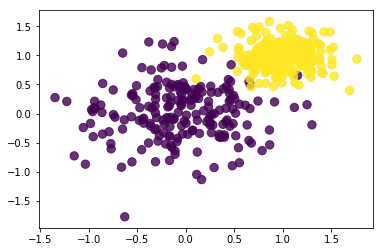

In [14]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

In [15]:
def generator_2cat(means, stds, npoints):

    X1 = np.random.multivariate_normal(mean=means[0], cov=np.diag(stds[0]), size=npoints)
    X2 = np.random.multivariate_normal(mean=means[1], cov=np.diag(stds[1]), size=npoints)
    
    return X1, X2


def generator_Ncat(means, stds, N, npoints):
    res = np.random.multivariate_normal(mean=means[0], cov=np.diag(stds[0]), size=npoints)
    
    for i in range(1,N):
        random_2d_gauss = np.random.multivariate_normal(mean=means[i], cov=np.diag(stds[i]), size=npoints)

        res = np.concatenate((res, random_2d_gauss))

    return res.reshape(N,npoints,2)
    

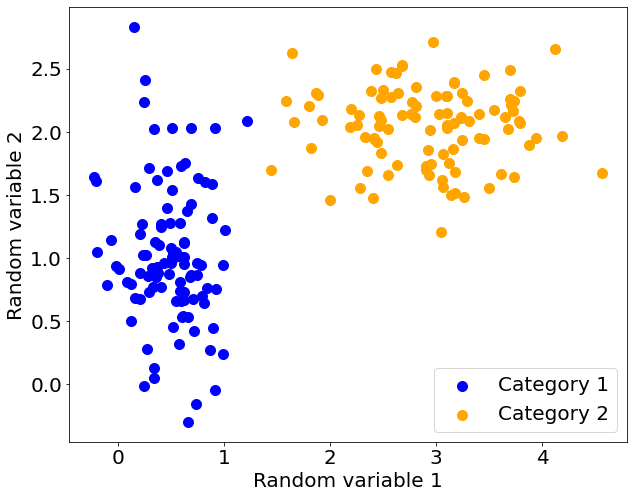

In [16]:
means = np.vstack((np.array([0.5, 1]),np.array([3, 2])))
stds = np.vstack((np.array([0.1, 0.3]),np.array([0.4, 0.1])))
npoints = 100

X1, X2 = generator_2cat(means, stds, npoints)


fig, ax = plt.subplots(figsize=(10,8))

plt.scatter(X1[:,0], X1[:,1], marker='o', s=100, c='blue', label='Category 1')
plt.scatter(X2[:,0], X2[:,1], marker='o', s=100, c='orange', label='Category 2')
plt.xticks(fontsize=20)
plt.xlabel('Random variable 1', fontsize=20)

plt.yticks(fontsize=20)
plt.ylabel('Random variable 2', fontsize=20)
plt.legend(fontsize=20)

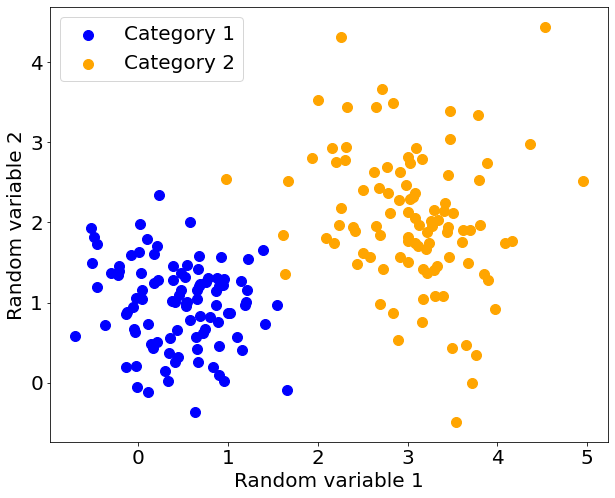

In [17]:
means_ = np.vstack((np.array([0.5, 1]),np.array([3, 2])))
stds_ = np.vstack((np.array([0.3, 0.3]),np.array([0.4, 0.8])))
npoints_ = 100
N_cat = 2

Xs = generator_Ncat(means=means_, stds=stds_, N=N_cat, npoints=npoints_)


fig, ax = plt.subplots(figsize=(10,8))

plt.scatter(Xs[0][:,0], Xs[0][:,1], marker='o', s=100, c='blue', label='Category 1')
plt.scatter(Xs[1][:,0], Xs[1][:,1], marker='o', s=100, c='orange', label='Category 2')
plt.xticks(fontsize=20)
plt.xlabel('Random variable 1', fontsize=20)

plt.yticks(fontsize=20)
plt.ylabel('Random variable 2', fontsize=20)
plt.legend(fontsize=20)


3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [18]:
!wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy

--2021-12-13 15:04:47--  https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/hgnvyj9abatk8g6/residuals_261.npy [following]
--2021-12-13 15:04:48--  https://www.dropbox.com/s/raw/hgnvyj9abatk8g6/residuals_261.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8af80a5d984e9e42f2f0d5f1ed.dl.dropboxusercontent.com/cd/0/inline/BbztEMk4EO5HQvcExLB6ke-V8EB9vimu8KNhMFi-i9eR19ShQ_L6CH4BZtdiCEiIelv_b8L88F_CiO29f8DBgVP0iG7fp9NAKBI_5mKl3ixKlxgqQ5tcPuXhMnJL6baBMm0WLZmNK-IU8N-qsmuTKZRA/file# [following]
--2021-12-13 15:04:48--  https://uc8af80a5d984e9e42f2f0d5f1ed.dl.dropboxusercontent.com/cd/0/inline/BbztEMk4EO5HQvcExLB6ke-V8EB9vimu8KNhMFi-i9eR19ShQ_L6CH4BZtdiCEiIelv_b8L8

In [20]:
from scipy.stats import linregress
import seaborn as sbs

/home/theivan/miniconda3/envs/datascience/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([-2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]), [])

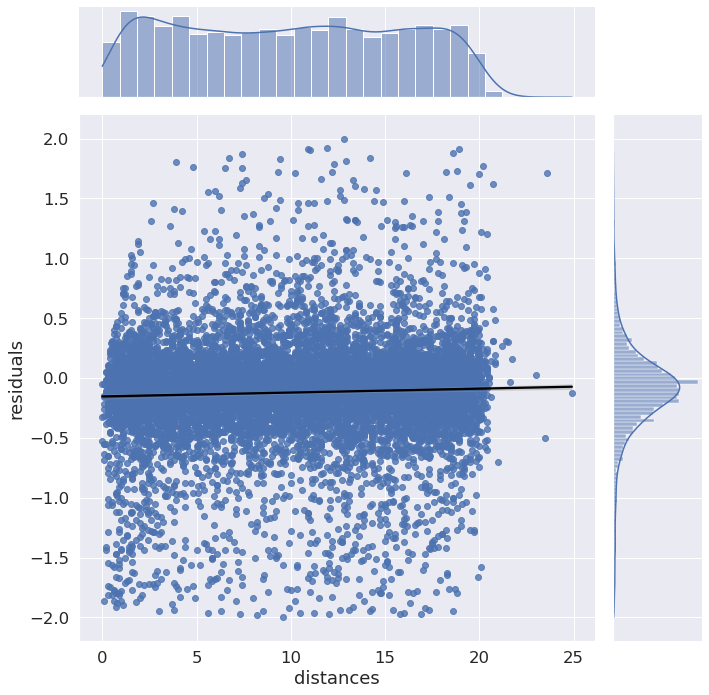

In [36]:
data = np.load('./residuals_261.npy', allow_pickle=True)
df = pd.DataFrame(data.item())
df_cleaned = df[abs(df['residuals']) < 2]

reg = linregress(df_cleaned['residuals'], df_cleaned['distances'])

#plt.plot(np.linspace(-2,2,100), reg.slope*np.linspace(-2,2,100) + reg.intercept)

sbs.set_theme(font_scale=1.5)
sbs.jointplot(df_cleaned['distances'], df_cleaned['residuals'], kind='reg', height=10,joint_kws={'line_kws':{'color':'black'}})

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


Text(0, 0.5, 'residuals')

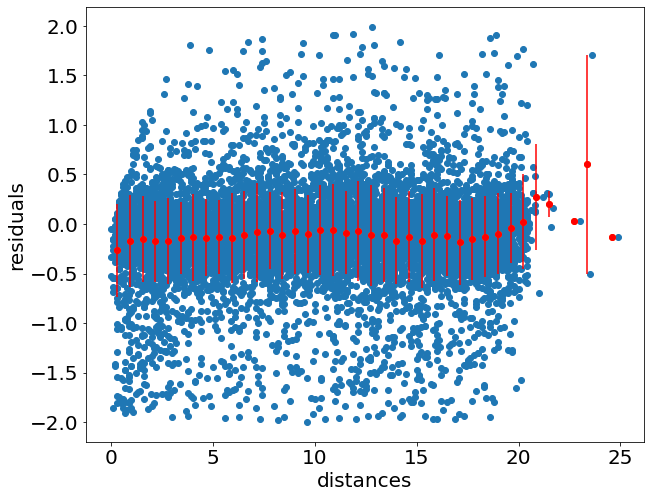

In [33]:
from scipy.stats import binned_statistic as bin_stat


hist = np.histogram(df_cleaned['distances'],bins=40)
x = (hist[1][1] - hist[1][0])/2 + hist[1][:-1]
y = bin_stat(df_cleaned['distances'],df_cleaned['residuals'], statistic='mean', bins=40)[0]
erry = bin_stat(df_cleaned['distances'],df_cleaned['residuals'], statistic='std', bins=40)[0]

fig, ax = plt.subplots(figsize=(10,8))
plt.scatter(df_cleaned['distances'], df_cleaned['residuals'])
plt.scatter(x,y)
plt.errorbar(x, y, yerr=erry, fmt="o", c='r')
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel('distances', fontsize=20)
plt.ylabel('residuals', fontsize=20)

